### importing the data from kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d simranvolunesia/pest-dataset

 71% 49.0M/69.5M [00:02<00:01, 15.1MB/s]
100% 69.5M/69.5M [00:02<00:00, 33.6MB/s]


In [ ]:
! unzip pest-dataset.zip

### importing modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam


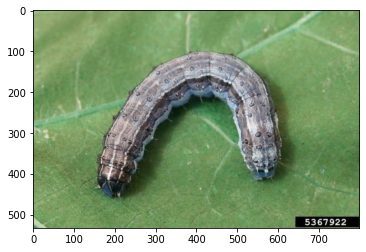

In [ ]:
img=cv2.imread('/content/pest/train/armyworm/jpg_0 - Copy (4).jpg')
plt.imshow(img)
plt.show()

In [ ]:
img=np.array(img)
img.shape

(533, 800, 3)

In [ ]:
train_dir='/content/pest/train/'
test_dir='/content/pest/test/'

In [ ]:
training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")


Found 2565 images belonging to 9 classes.


In [ ]:
validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)


Found 135 images belonging to 9 classes.


In [ ]:
testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)

Found 450 images belonging to 9 classes.


In [ ]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

In [ ]:
mobilenet.trainable=False

In [ ]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1024)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

In [ ]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history=model.fit(training,validation_data=validing,epochs=20,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/20
10/10 - 15s - loss: 2.2401 - accuracy: 0.3375 - val_loss: 6.1764 - val_accuracy: 0.3750 - lr: 0.0010 - 15s/epoch - 2s/step
Epoch 2/20
10/10 - 3s - loss: 1.8997 - accuracy: 0.5125 - val_loss: 7.4358 - val_accuracy: 0.1250 - lr: 0.0010 - 3s/epoch - 324ms/step
Epoch 3/20
10/10 - 3s - loss: 1.7228 - accuracy: 0.5500 - val_loss: 4.8211 - val_accuracy: 0.3750 - lr: 0.0010 - 3s/epoch - 297ms/step
Epoch 4/20
10/10 - 3s - loss: 1.3727 - accuracy: 0.5813 - val_loss: 1.9177 - val_accuracy: 0.6250 - lr: 0.0010 - 3s/epoch - 298ms/step
Epoch 5/20
10/10 - 3s - loss: 1.4183 - accuracy: 0.6510 - val_loss: 2.3205 - val_accuracy: 0.5000 - lr: 0.0010 - 3s/epoch - 308ms/step
Epoch 6/20
10/10 - 5s - loss: 1.5173 - accuracy: 0.5875 - val_loss: 1.1953 - val_accuracy: 0.6875 - lr: 0.0010 - 5s/epoch - 471ms/step
Epoch 7/20
10/10 - 3s - loss: 0.9152 - accuracy: 0.7375 - val_loss: 1.5290 - val_accuracy: 0.5000 - lr: 0.0010 - 3s/epoch - 280ms/step
Epoch 8/20
10/10 - 3s - loss: 0.9166 - accuracy: 0.6875 

In [ ]:
loss , acc = model.evaluate(testing)

29/29 [==============================] - 2s 80ms/step - loss: 0.6821 - accuracy: 0.8244


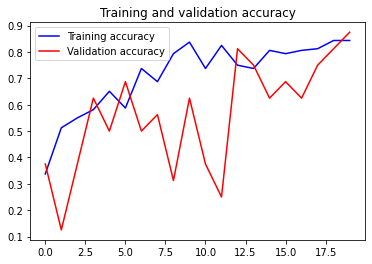

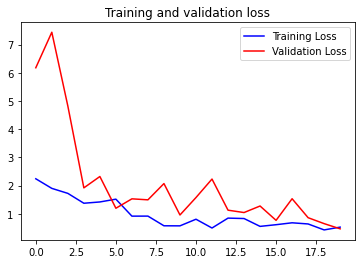

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction


In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


In [ ]:
img_height = 224
img_width = 224

In [ ]:
def print_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = preprocess_input(img_tensor)
    featuremap = model.predict(img_tensor)
    featuremap_ = ["{:f}".format(float(x)) for x in featuremap[0]]
    print(featuremap_)
    index = np.argmax(featuremap_)
    print(class_list[index])
    plt.imshow(img)


In [ ]:
class_list = ['aphids','armyworm','beetle','bollworm','grasshopper','mites' ,'mosquito','sawfly ','stem_borer']

['0.000001', '0.999259', '0.000062', '0.000028', '0.000007', '0.000013', '0.000007', '0.000077', '0.000547']
armyworm


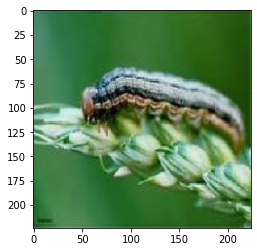

In [ ]:
img_path = '/content/pest/test/armyworm/jpg_10 - Copy.jpg'
print_image(img_path)

['0.000961', '0.000710', '0.001258', '0.000022', '0.003912', '0.000017', '0.985200', '0.007836', '0.000084']
mosquito


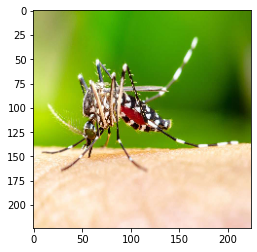

In [ ]:
img_path = '/content/pest/test/mosquito/jpg_10.jpg'
print_image(img_path)

['0.000006', '0.000053', '0.003191', '0.000357', '0.213416', '0.000072', '0.277045', '0.504808', '0.001052']
sawfly 


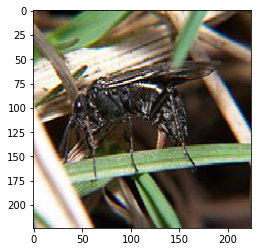

In [ ]:
img_path = '/content/pest/test/sawfly/jpg_10.jpg'
print_image(img_path)


In [ ]:
#! pip install tensorflowjs

     |████████████████████████████████| 77 kB 4.3 MB/s 


In [ ]:
#import tensorflowjs as tfjs

In [ ]:
#tfjs_target_dir="/content/Model"

In [ ]:
#tfjs.converters.save_keras_model(model, tfjs_target_dir)